In [1]:
import torch
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

c:\anaconda\envs\fp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
,  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="test/images/", split="train")

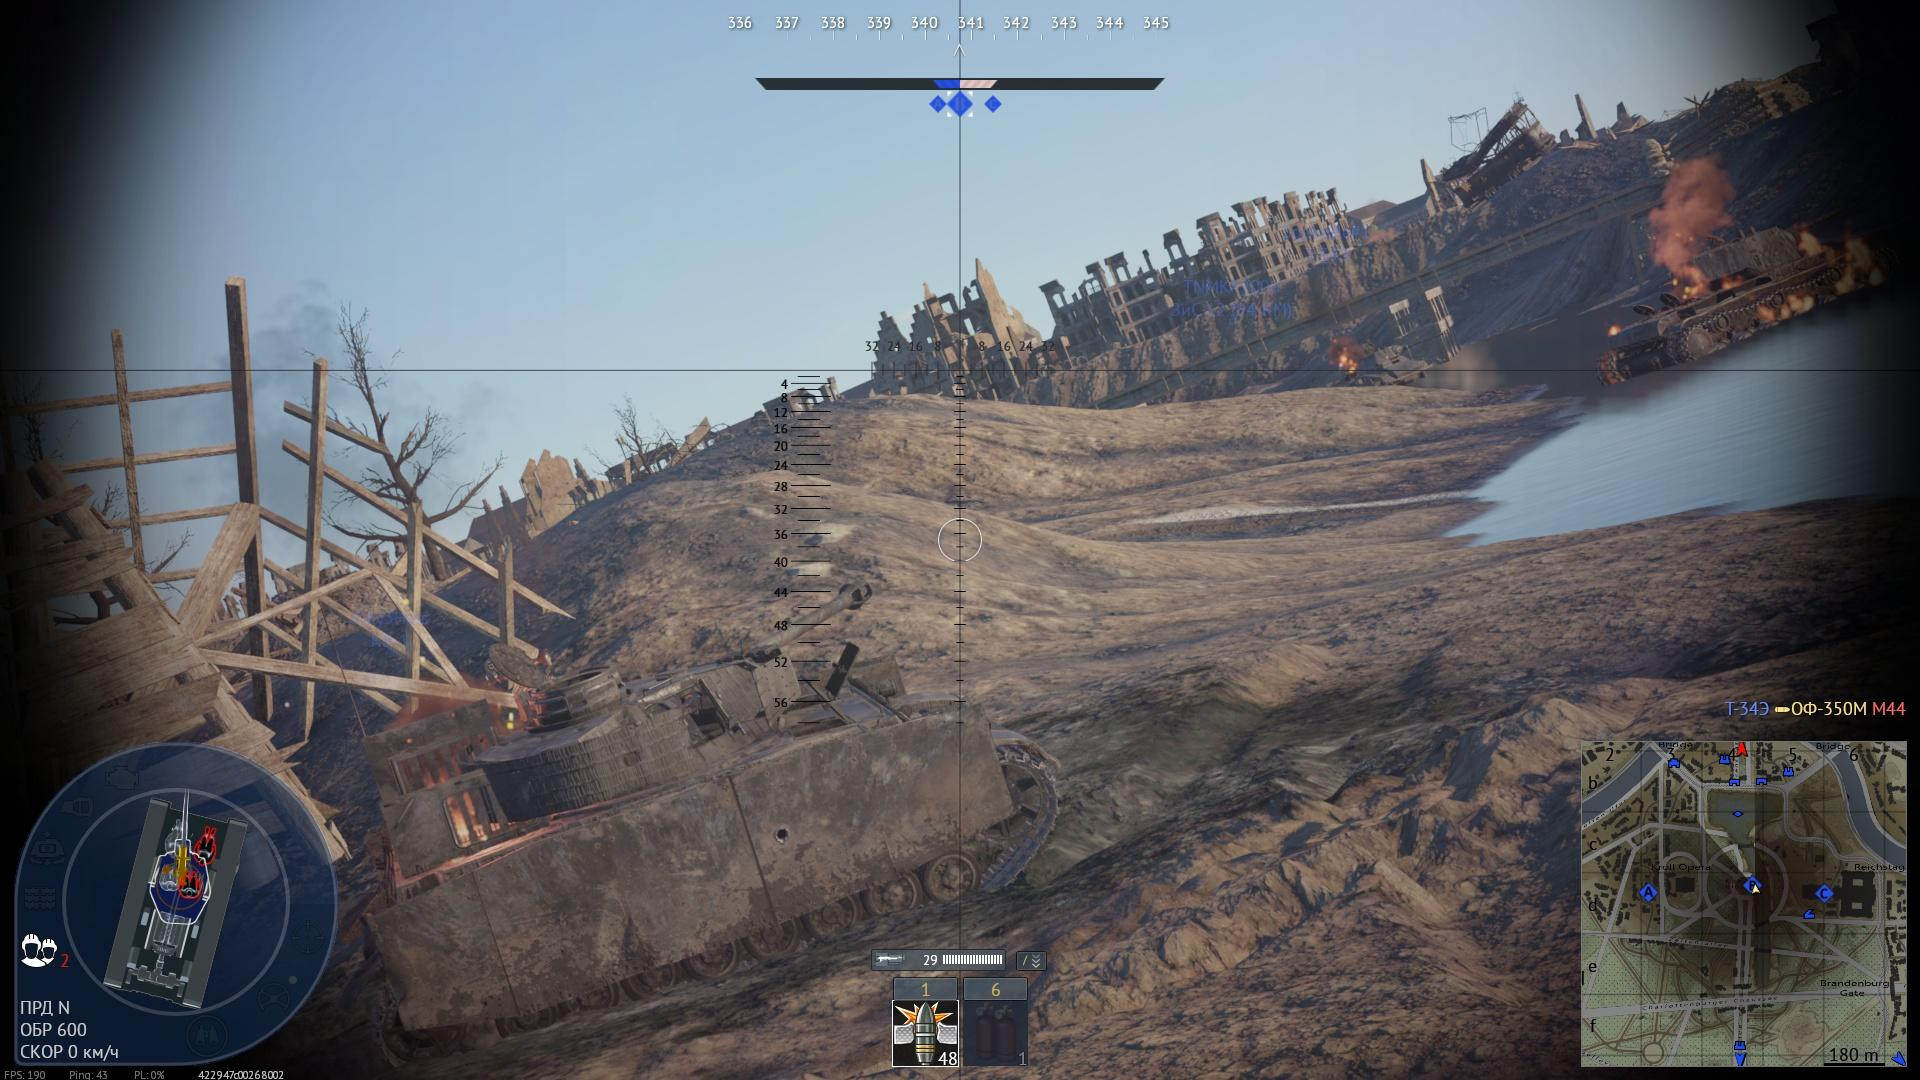

In [ ]:
import numpy as np
from PIL import Image

idx = 46

# load image
image = dataset[idx]["image"]
IMAGE_ORIGINAL_W, IMAGE_ORIGINAL_H = image.size
image

In [402]:
image = image.resize((256,256), Image.BICUBIC)
SCALE_X, SCALE_Y = 256 / IMAGE_ORIGINAL_W, 256 / IMAGE_ORIGINAL_H
input_boxes = dataset[idx]["objects"]["bbox"]

for i in range(len(input_boxes)):
    input_boxes[i][0] *= SCALE_X
    input_boxes[i][1] *= SCALE_Y
    input_boxes[i][2] *= SCALE_X
    input_boxes[i][3] *= SCALE_Y

In [403]:
from PIL import ImageDraw
test = image.copy()
imgd = ImageDraw.Draw(test) 

for i in range(len(input_boxes)):
    x1, y1, x2, y2 = input_boxes[i]
    print(x1, y1, x2, y2)
    imgd.rectangle([x1, y1, x2, y2])

34.93333333333333 76.08888888888889 247.73333333333332 204.8


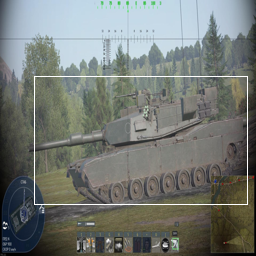

In [404]:
test

In [405]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(input_boxes)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[input_boxes], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

[[34.93333333333333, 76.08888888888889, 247.73333333333332, 204.8]]
,pixel_values torch.Size([1, 3, 1024, 1024])
,original_sizes torch.Size([1, 2])
,reshaped_input_sizes torch.Size([1, 2])
,input_boxes torch.Size([1, 1, 4])


In [406]:
model.to(device)

# forward pass
# note that the authors use `multimask_output=False` when performing inference
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [407]:
outputs.pred_masks.shape

torch.Size([1, 1, 1, 256, 256])

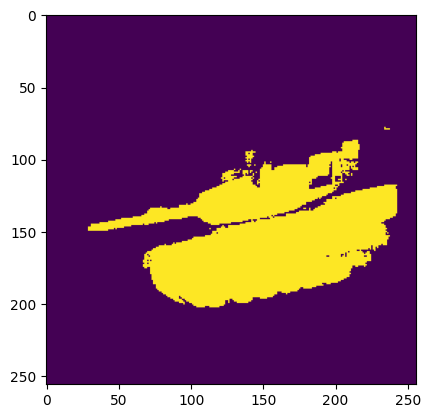

In [408]:
import matplotlib.pyplot as plt

pred_maskses = outputs.pred_masks
pred_maskses = torch.reshape(pred_maskses, (-1, 256, 256))
pred_maskses = torch.sigmoid(pred_maskses)
pred_maskses = (pred_maskses > 0.5)
pred_maskses = pred_maskses.cpu().numpy()

for i in range(len(pred_maskses)):
    plt.figure()
    plt.imshow(pred_maskses[i])

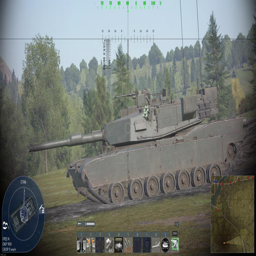

In [409]:
image

Centroid: (153, 151)
,217.5 329.0625 1815.0 852.1875
,[[135.5, 140.0]]


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

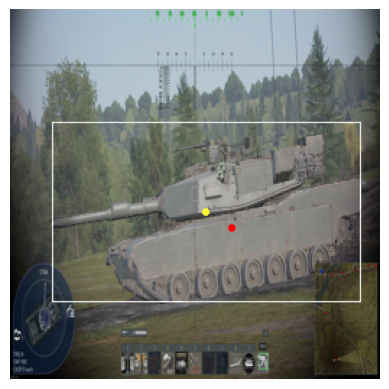

In [ ]:
import cv2 
import imutils
from PIL import ImageDraw


fig, axes = plt.subplots()

image_arr = np.array(image)
image_PIL_square = Image.fromarray(image_arr)
image_PIL_square = image_PIL_square.convert("RGBA")
image_PIL_square = image_PIL_square.resize((256,256), Image.BICUBIC)

bbox_centers = []
contour_centers = []

center_to_cropimg = dict()

for i in range(len(pred_maskses)):
    mask_image = Image.fromarray(pred_maskses[i])
    mask_image = mask_image.convert("RGBA")
    mask_image = mask_image.resize((256, 256), Image.BICUBIC)
    
    ys, xs = np.nonzero(pred_maskses[i])
    if len(xs) > 0:
        cX = int(np.mean(xs))
        cY = int(np.mean(ys))
        contour_centers.append([cX, cY])

    # print(pred_maskses[i])
    min_x, min_y, max_x, max_y = float('inf'), float('inf'), -1, -1
    for ycoord in range(len(pred_maskses[i])):
        for xcoord in range(len(pred_maskses[i][ycoord])):
            if pred_maskses[i][ycoord][xcoord]:
                min_x = min(min_x, xcoord)
                max_x = max(max_x, xcoord)
                min_y = min(min_y, ycoord)
                max_y = max(max_y, ycoord)
    
    bbox_centers.append([(min_x + max_x) / 2, (min_y + max_y) / 2])

    print(min_x * (1/SCALE_X), min_y * (1/SCALE_Y), max_x * (1/SCALE_X), max_y * (1/SCALE_Y))
    imgd = ImageDraw.Draw(image_PIL_square)
    imgd.rectangle([min_x, min_y, max_x, max_y])
    image_PIL_square = Image.blend(image_PIL_square, mask_image, alpha=0.10)
    
    center_to_cropimg[((min_x + max_x) / 2, (min_y + max_y) / 2)] = np.array(image_PIL_square)[min_x:max_x, min_y:max_y, :]

print(bbox_centers)
imgd = ImageDraw.Draw(image_PIL_square)
for i in range(len(bbox_centers)):
    imgd.ellipse([bbox_centers[i][0]-2, bbox_centers[i][1]-2, bbox_centers[i][0]+2, bbox_centers[i][1]+2], fill="#ffff33")
    imgd.ellipse([contour_centers[i][0]-2, contour_centers[i][1]-2, contour_centers[i][0]+2, contour_centers[i][1]+2], fill="red")

image_PIL_square = image_PIL_square.resize((256, 256), Image.BICUBIC)
axes.imshow(image_PIL_square)
axes.axis("off")

In [411]:
# TODO: generate robot trajectories, assuming that top left corner is (0,0)

ORIGIN_X = 0
ORIGIN_Y = 0

for bbox_center in bbox_centers:
    print(bbox_center[0] / IMAGE_ORIGINAL_W, bbox_center[1] / IMAGE_ORIGINAL_H)

0.07057291666666667 0.12962962962962962
